In [1]:

from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import xgboost as xgb
import gc
import sys
import os
sys.path.append(os.path.abspath("../../.."))


from Preprocessing.preprocessing_pipeline_impute import preprocessing_pipeline
from Preprocessing.imputation import get_imputation_maps, apply_imputation,ContextImputer
from Preprocessing.preprocessing_pipeline_segment import preprocessing_pipeline_segment
from Preprocessing.get_all_data import get_full_data
from Preprocessing.split_new import split_data
from utils.eval_call import evaluate_model
from utils.scatter_plot import scatter_prediction

In [2]:
X_train, X_test, y_train, y_test, categorical_features , numeric_features = split_data('../../../data.csv', segment= True)

# Preprocessing
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


xgb_pipeline = Pipeline([
    ('imp_fc', ContextImputer('fuel_consumption_l_100km')),
    ('imp_ps', ContextImputer('power_ps')),
    ('imp_er', ContextImputer('electric_range')),
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(
        n_estimators=855,
        learning_rate=0.09200654190149193,
        max_depth=9,
        subsample=0.9757995766256756,         
        colsample_bytree=0.7246844304357644,
        gamma=2.600340105889054,
        min_child_weight=2,
        random_state=42,
        n_jobs=-1
    ))
])

# Cross Validation – KFold mit Shuffle und Seed
kf = KFold(n_splits= 10, shuffle=True, random_state=42)
y_pred = cross_val_predict(xgb_pipeline, X_train, y_train, cv=kf)

# Evaluation
print('Cross Validation Training:')
print("MAE:", round(mean_absolute_error(y_train, y_pred),2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_train, y_pred)),2))
print("R²:", round(r2_score(y_train, y_pred),2))

    # Modell trainieren
xgb_pipeline.fit(X_train, y_train)

# Vorhersagen treffen
y_pred_xgb = xgb_pipeline.predict(X_test)

evaluate_model(y_test, y_pred_xgb, "Xgb Boost")


Cross Validation Training:
MAE: 3420.29
RMSE: 13845.96
R²: 0.84
Xgb Boost Performance Metrics:
MAE: 3571.82
MAPE: 16.78
RMSE: 28664.11
R²: 0.61
------------------------------


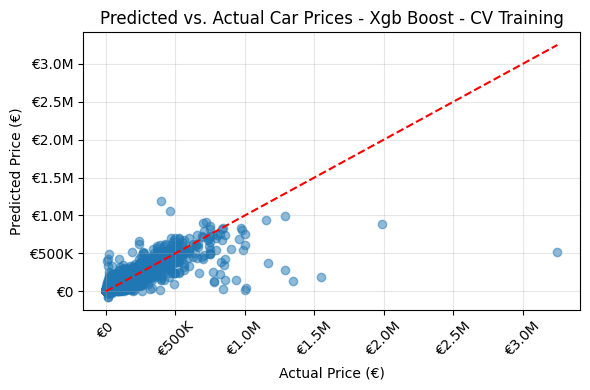

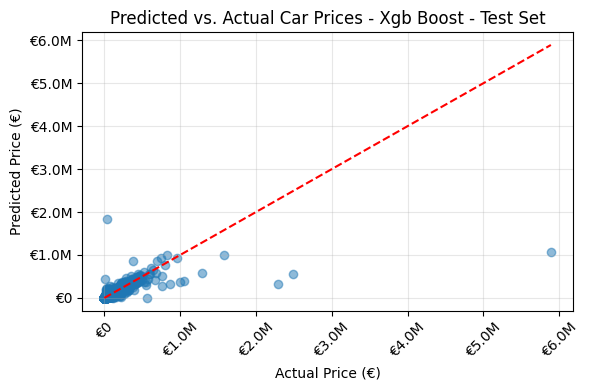

In [3]:
scatter_prediction(y_train, y_pred, "Xgb Boost - CV Training")
scatter_prediction(y_test, y_pred_xgb, "Xgb Boost - Test Set")

### EDA

In [4]:
import pandas as pd

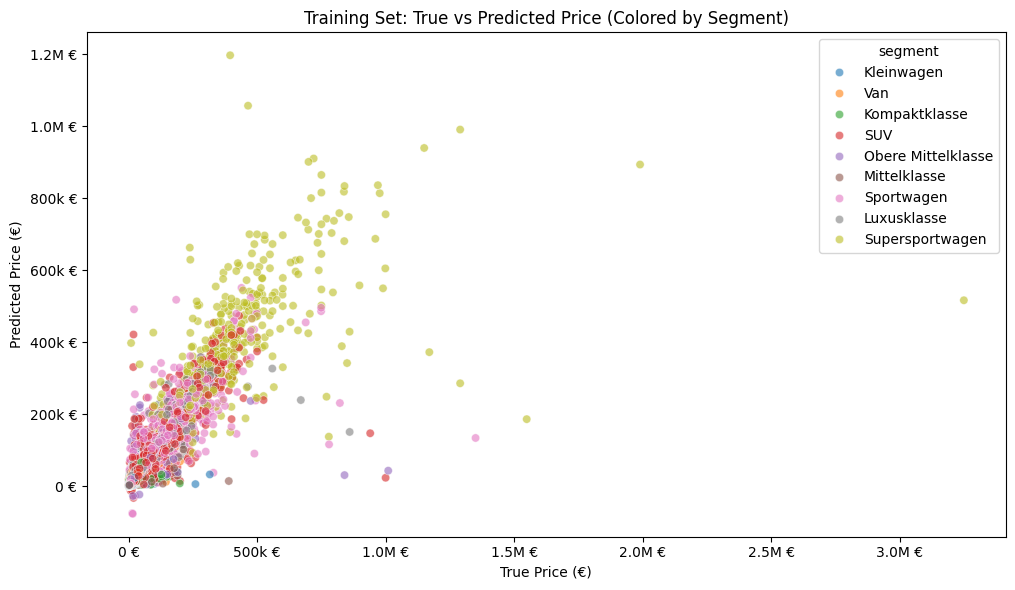

In [5]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train, y=y_pred, hue=X_train['segment'], palette='tab10', alpha=0.6, legend='full')
plt.xlabel("True Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Training Set: True vs Predicted Price (Colored by Segment)")
plt.tight_layout()

def thousands_formatter(x, pos):
    if abs(x) >= 1_000_000:
        return f"{x/1_000_000:.1f}M €"
    elif abs(x) >= 1_000:
        return f"{x/1_000:.0f}k €"
    else:
        return f"{int(x)} €"

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.show()

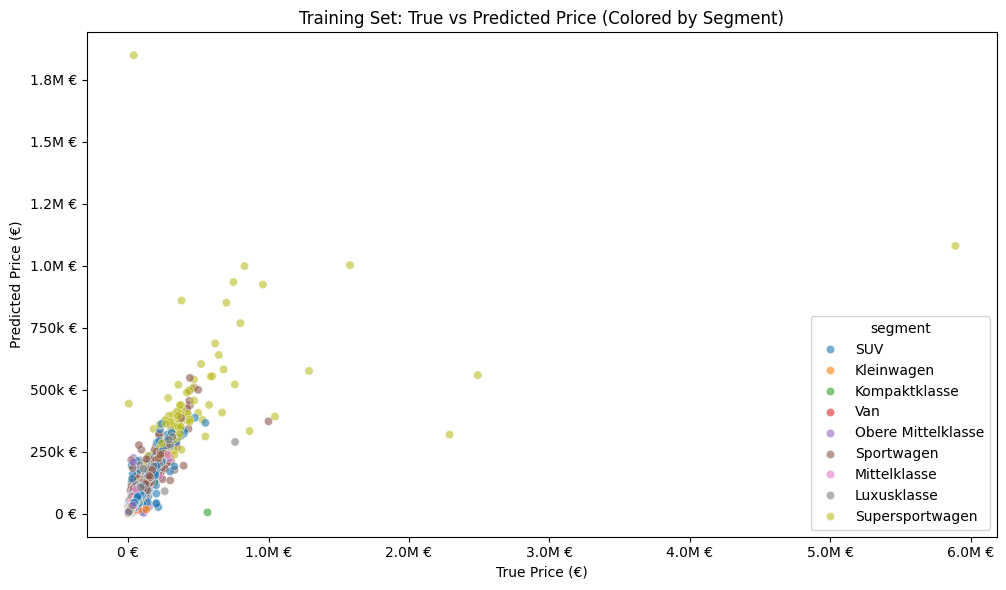

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D
import seaborn as sns



plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, hue=X_test['segment'], palette='tab10', alpha=0.6, legend='full')
plt.xlabel("True Price (€)")
plt.ylabel("Predicted Price (€)")
plt.title("Training Set: True vs Predicted Price (Colored by Segment)")
plt.tight_layout()

def thousands_formatter(x, pos):
    if abs(x) >= 1_000_000:
        return f"{x/1_000_000:.1f}M €"
    elif abs(x) >= 1_000:
        return f"{x/1_000:.0f}k €"
    else:
        return f"{int(x)} €"

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.show()

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

segment_metrics = []
for segment in X_test['segment'].unique():
    idx = X_test['segment'] == segment
    y_true = y_test[idx]
    y_pred_seg = y_pred_xgb[idx]
    mae = round(mean_absolute_error(y_true, y_pred_seg),2)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred_seg)),2)
    mape = round(mean_absolute_percentage_error(y_true, y_pred_seg) * 100,2)
    segment_metrics.append({
        'segment': segment,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

segment_metrics_df = pd.DataFrame(segment_metrics)
print(segment_metrics_df.sort_values(by = 'MAPE'))

              segment        MAE       RMSE   MAPE
0                 SUV    3696.32    8288.02  11.58
2       Kompaktklasse    2072.84    6608.95  15.54
1          Kleinwagen    1812.77    3693.49  16.41
4  Obere Mittelklasse    3974.75    8930.08  20.19
6        Mittelklasse    2655.97    4938.52  20.96
3                 Van    3308.44    5745.72  21.07
5          Sportwagen    8811.84   23133.08  21.40
7         Luxusklasse   10954.05   25562.15  24.17
8     Supersportwagen  131226.98  484749.37  97.84


In [8]:

# Define price bins and labels
price_bins = [0, 20000, 40000, 60000, 100000, np.inf]
price_labels = ['<20k', '20k-40k', '40k-60k', '60k-100k', '>100k']

# Assign each test sample to a price segment
price_segment = pd.cut(y_test, bins=price_bins, labels=price_labels)

# Calculate metrics for each price segment
price_segment_metrics = []
for seg in price_labels:
    idx = price_segment == seg
    y_true = y_test[idx]
    y_pred_seg = y_pred_xgb[idx]
    if len(y_true) == 0:
        continue
    mae = round(mean_absolute_error(y_true, y_pred_seg), 2)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred_seg)), 2)
    mape = round(mean_absolute_percentage_error(y_true, y_pred_seg) * 100, 2)
    price_segment_metrics.append({
        'price_segment': seg,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    })

price_segment_metrics_df = pd.DataFrame(price_segment_metrics)
print(price_segment_metrics_df.sort_values(by='MAPE'))

  price_segment       MAE       RMSE   MAPE
1       20k-40k   3133.55   15084.21  11.03
2       40k-60k   5789.12    9222.59  11.87
4         >100k  38579.41  190516.08  13.76
3      60k-100k  10440.32   17483.23  13.86
0          <20k   1769.02    3992.32  21.60


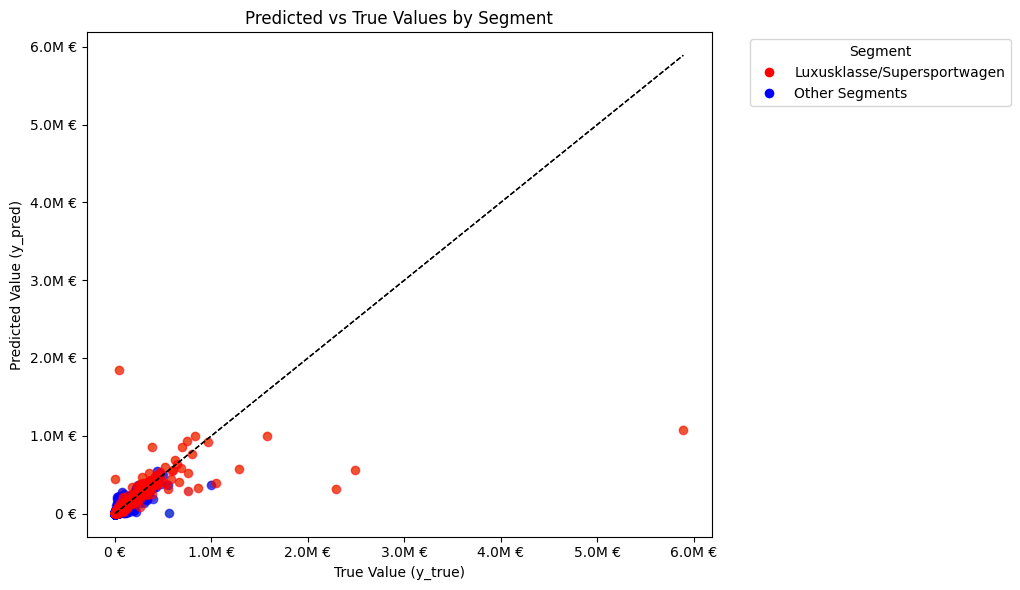

In [9]:
from matplotlib.lines import Line2D

results = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred_xgb,
    'segment': X_test['segment']
})

plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x='y_true', y='y_pred', hue='segment', alpha=0.6, palette='tab10')
plt.plot([results.y_true.min(), results.y_true.max()],
         [results.y_true.min(), results.y_true.max()],
         color='black', linestyle='--', linewidth=1)
plt.xlabel("True Value (y_true)")
plt.ylabel("Predicted Value (y_pred)")
plt.title("Predicted vs True Values by Segment")
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
custom_palette = {'Luxusklasse': 'red', 'Supersportwagen': 'red'}
default_color = 'blue'

# Assign colors: red for the two segments, blue for the rest
results['color'] = results['segment'].map(lambda x: custom_palette.get(x, default_color))

# Plot
for seg in results['segment'].unique():
    subset = results[results['segment'] == seg]
    plt.scatter(subset['y_true'], subset['y_pred'],
                color=custom_palette.get(seg, default_color),
                alpha=0.6, label=seg if seg in custom_palette else None)

# Plot the reference line
plt.plot([results.y_true.min(), results.y_true.max()],
         [results.y_true.min(), results.y_true.max()],
         color='black', linestyle='--', linewidth=1)

# Custom legend: only show the two highlighted segments and "Other"
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Luxusklasse/Supersportwagen', markerfacecolor='red', markersize=8),
    Line2D([0], [0], marker='o', color='w', label='Other Segments', markerfacecolor='blue', markersize=8)
]
plt.legend(handles=legend_elements, title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
# Format both axes with thousands separator and Euro sign
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x):,} €"))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f"{int(y):,} €"))
import matplotlib.ticker as mticker
# Prepare the results DataFrame if not already present

def thousands_formatter(x, pos):
    if abs(x) >= 1_000_000:
        return f"{x/1_000_000:.1f}M €"
    elif abs(x) >= 1_000:
        return f"{x/1_000:.0f}k €"
    else:
        return f"{int(x)} €"

plt.gca().xaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))
plt.show()

<Figure size 1500x1000 with 0 Axes>

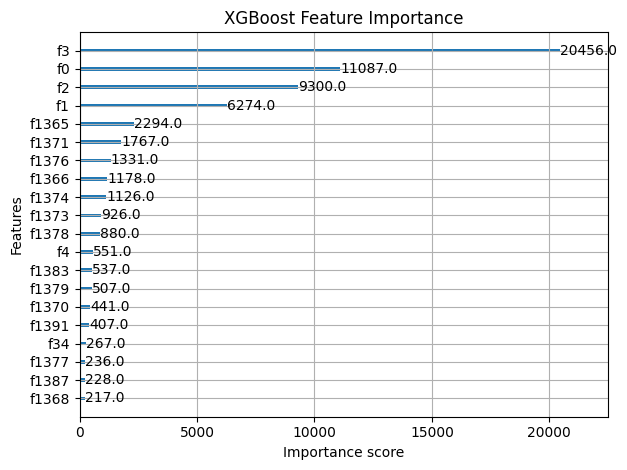

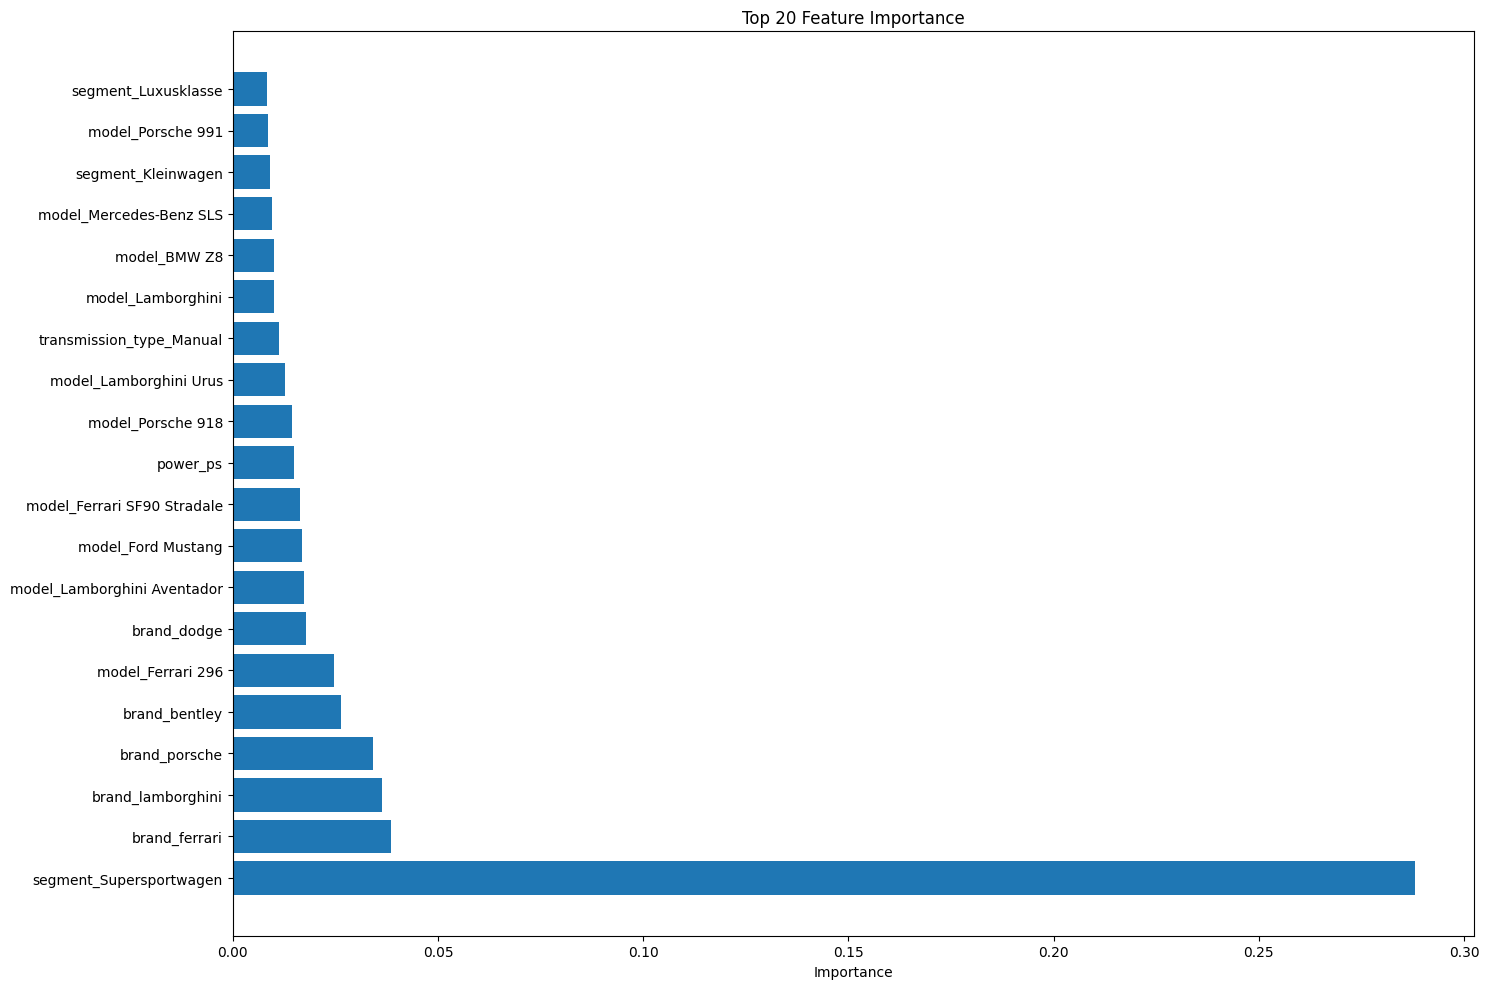

In [11]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Extract the XGBoost model from the pipeline
xgb_model = xgb_pipeline.named_steps['model']

# Get feature names from preprocessor
preprocessor = xgb_pipeline.named_steps['preprocessor']
feature_names = []

# Get numeric feature names
numeric_features

# Get one-hot encoded categorical feature names
ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
categorical_features = ohe.get_feature_names_out(input_features=categorical_features)

# Combine all feature names
all_features = list(numeric_features) + list(categorical_features)

# Plot feature importance with a good figure size
plt.figure(figsize=(15, 10))
plot_importance(xgb_model, max_num_features=20, title='XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Additional plot showing importance with feature names
importances = xgb_model.feature_importances_

# Create an array of feature importances with their names
feature_importance = []
for i, importance in enumerate(importances):
    if i < len(all_features):
        feature_importance.append((all_features[i], importance))

# Sort by importance
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Plot custom feature importance
plt.figure(figsize=(15, 10))
features = [x[0] for x in feature_importance[:20]]
importance_values = [x[1] for x in feature_importance[:20]]

plt.barh(range(len(features)), importance_values, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()